In [1]:
library(Seurat)
library(SeuratWrappers)
library(ggplot2)
library(cowplot)
library(monocle3)
library(dplyr)
library(tidyr)
library(future)
library(stringr)
library(scRepertoire)
library(Trex)
library(patchwork)
library(ggrepel)
library(slingshot)
library(scExtras)
library(rstatix)
library(pROC)
library(UCell)
library(ggraph)
library(circlize)
library(scales)
library(scDblFinder)
library(BiocParallel)
library(org.Mm.eg.db)
library(clusterProfiler)
library(enrichplot)
library(tibble)
library(ggpubr)
library(tidydr)
library(corrplot)
library(harmony)
library(reshape2)
library(ComplexHeatmap)
library(RColorBrewer)
library(randomcoloR)
library(escape)
library(ggridges)
library(scatterpie)
options(jupyter.plot_scale=1, repr.matrix.max.cols=200)
`%nin%` = Negate(`%in%`)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVi

In [2]:
update_geom_defaults("point", aes(stroke = 0.1))
source('utils_tcr.R')

In [3]:
tc <- readRDS('data/b16_tc_5batch.rds')

# TCR

In [4]:
tcr_path <- function(batch, sample) file.path('~/data1/eva/cellranger_out', batch, sample, 'outs/per_sample_outs', sample, 
                                  'vdj_t/filtered_contig_annotations.csv')
tcrb1A <- read.csv(tcr_path('b16_oct2022', 'A'))
tcrb1A1 <- read.csv(tcr_path('b16_oct2022', 'A1'))
tcrb1A2 <- read.csv(tcr_path('b16_oct2022', 'A2'))
tcrb1B <- read.csv(tcr_path('b16_oct2022', 'B'))
tcrb2A <- read.csv(tcr_path('b16_jun2023', 'A'))
tcrb2B <- read.csv(tcr_path('b16_jun2023', 'B'))
tcrb2C <- read.csv(tcr_path('b16_jun2023', 'C'))
tcrb2D <- read.csv(tcr_path('b16_jun2023', 'D'))
tcrb3A <- read.csv(tcr_path('b16_feb2024', 'A'))
tcrb3B1 <- read.csv(tcr_path('b16_feb2024', 'B1'))
tcrb3B2 <- read.csv(tcr_path('b16_feb2024', 'B2'))
tcrb3C <- read.csv(tcr_path('b16_feb2024', 'C'))
tcrb4A <- read.csv(tcr_path('b16_mar2024', 'A'))
tcrb4B1 <- read.csv(tcr_path('b16_mar2024', 'B1'))
tcrb4B2 <- read.csv(tcr_path('b16_mar2024', 'B2'))
tcrb4C <- read.csv(tcr_path('b16_mar2024', 'C'))
tcrb5A <- read.csv(tcr_path('b16_aug2024', 'A'))
tcrb5B1 <- read.csv(tcr_path('b16_aug2024', 'B1'))
tcrb5B2 <- read.csv(tcr_path('b16_aug2024', 'B2'))
tcrb5C <- read.csv(tcr_path('b16_aug2024', 'C'))

In [5]:
contig.list <- list(tcrb1A, tcrb1A1, tcrb1A2, tcrb1B, 
                    tcrb2A, tcrb2B, tcrb2C, tcrb2D, 
                    tcrb3A, tcrb3B1, tcrb3B2, tcrb3C, 
                    tcrb4A, tcrb4B1, tcrb4B2, tcrb4C, 
                    tcrb5A, tcrb5B1, tcrb5B2, tcrb5C)
combined_tcr <- combineTCR(contig.list, 
                samples = paste0('S',1:20))

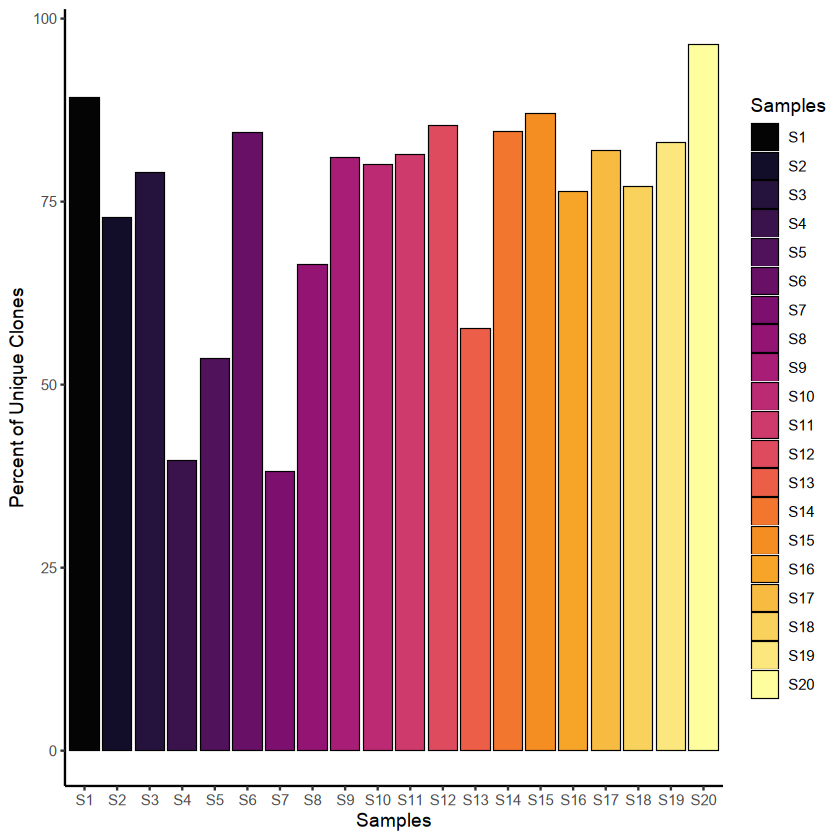

In [6]:
clonalQuant(combined_tcr, cloneCall="aa", scale = T)

### merge RNA and TCR data

In [7]:
tc_tcr <- RenameCells(tc, new.names = paste(tc$sample,str_split_fixed(rownames(tc@meta.data), '_',3)[,3],sep='_'))
tc_tcr <- combineExpression(combined_tcr, tc_tcr, 
                  cloneCall="aa", 
                  group.by = "sample", 
                  proportion = FALSE, 
                  cloneSize=c(Single=1, Small=5, Medium=20, Large=100, Hyperexpanded=1000))
tc_tcr$cloneSize <- droplevels(tc_tcr$cloneSize)
tc_tcr <- correct_cd_subset(tc_tcr)
tc_tcr@meta.data <- tc_tcr@meta.data[,!str_detect(colnames(tc_tcr@meta.data),'RNA_snn')]
tc_tcr <- AddMetaData(tc_tcr, data.frame(Embeddings(tc_tcr, 'umap')))

In [8]:
tc_tcr <- readRDS('data/b16_tc_tcr_5batch.rds')

In [9]:
tc_tcr_n <- tc_tcr@meta.data %>% group_by(sample) %>% summarise(ncell=n(),nclone=length(unique(CTaa)))
cloneSize_df <- tc_tcr@meta.data %>% 
    group_by(sample, VLP, aCTLA4, cloneSize, .drop=FALSE) %>% summarise(count=n()) %>% 
    ungroup() %>% group_by(sample) %>% mutate(count_sample = sum(count)) %>% 
    mutate(ratio = count/count_sample, Percent=ratio*100) 
tcr_bysample1 <- ggplot(tc_tcr_n, aes(x=sample, y=ncell)) + geom_col(fill='deepskyblue', color='black') + labs(y='# T cells') +
    theme_cowplot() + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
                            axis.title.x=element_blank(), axis.line.x=element_blank())
tcr_bysample2 <- ggplot(tc_tcr_n, aes(x=sample, y=nclone)) + geom_col(fill='cadetblue', color='black') + labs(y='# clonotypes') +
    theme_cowplot() + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
                            axis.title.x=element_blank(), axis.line.x=element_blank())
tcr_bysample3 <- ggplot(cloneSize_df, aes(y=Percent, x=sample, fill=cloneSize)) + geom_col(color='black') + theme_cowplot() + 
    scale_fill_manual(values=rev(brewer.pal(5, 'YlOrRd')), labels=str_replace(levels(cloneSize_df$cloneSize), ' \\(','\n\\(')) + 
    labs(y='Percentage', x='Sample', fill='Clone size') + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), legend.key.height = unit(2, 'lines'),
                            axis.title.x=element_blank(), axis.line.x=element_blank())
tcr_bysample4 <- ggplot(cloneSize_df %>% distinct(sample, VLP, aCTLA4) %>% melt(id.vars='sample') %>% 
                        mutate(variable=recode(variable, 'aCTLA4'='αCTLA4')), 
                        aes(x=sample, y=variable, fill=value)) + geom_raster() + theme_cowplot() +
    scale_fill_manual(values=c('purple','blue','cyan')) + labs(y='', x='Sample',fill='Treatment')  +
    theme(axis.text.x=element_text(size=9, angle=90, hjust=1, vjust=0.5))

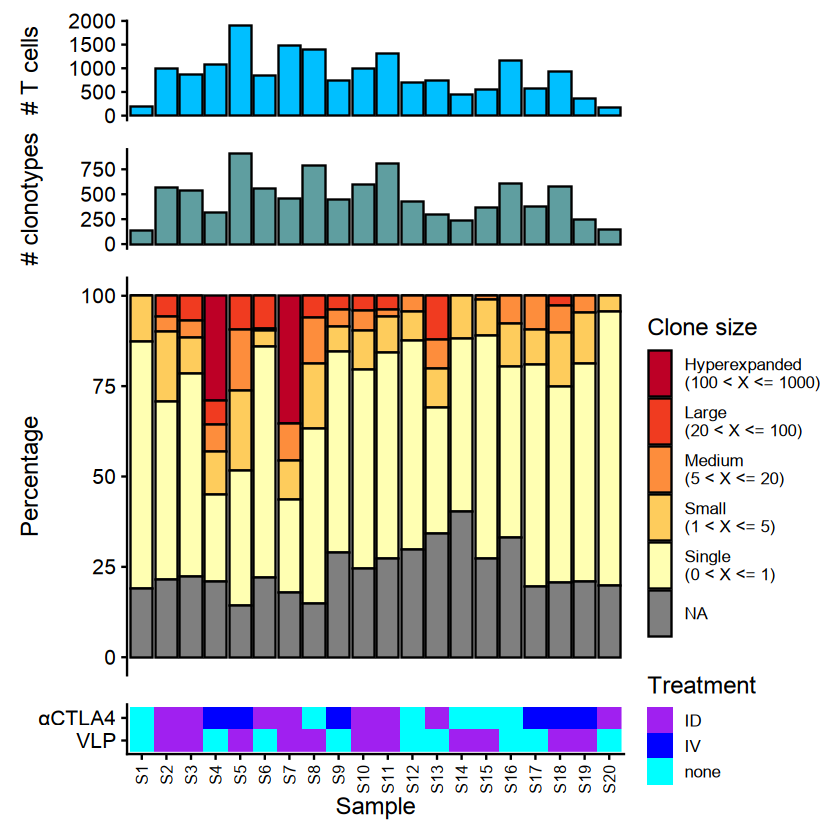

In [10]:
tcr_bysample1 + tcr_bysample2 + tcr_bysample3 + tcr_bysample4 + plot_layout(ncol = 1, heights=c(1,1,4,0.5)) &
    theme(legend.text=element_text(size=10))
ggsave('plot/b16_tcr_stat_sample.pdf', width=5.5, height=7, device=cairo_pdf)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


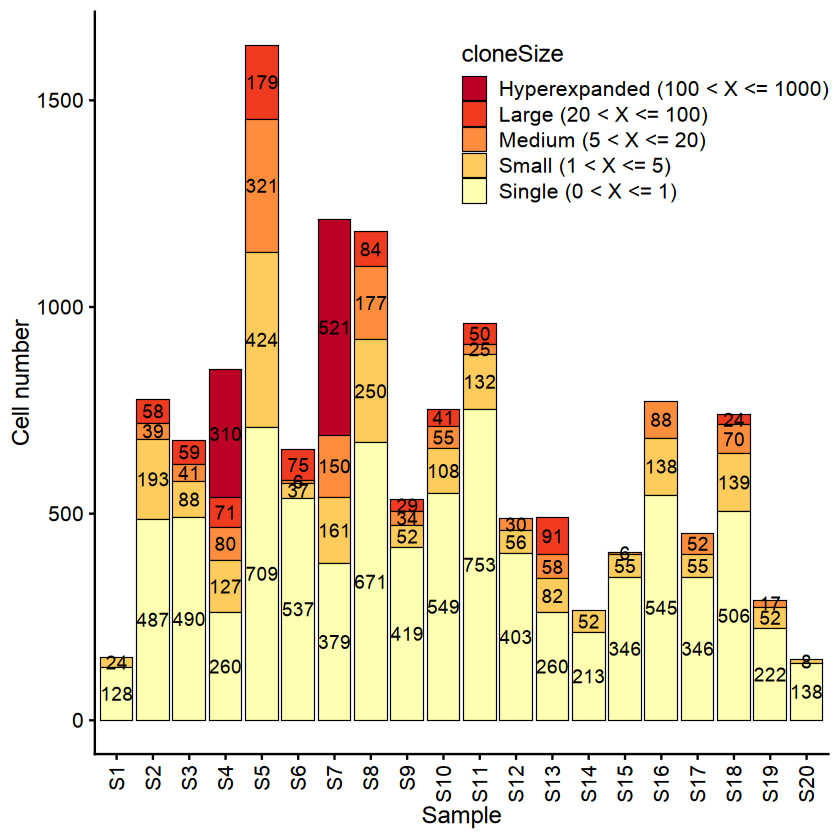

In [11]:
clonalOccupy(tc_tcr, x.axis = "sample") + scale_fill_manual(values=rev(brewer.pal(5, 'YlOrRd'))) + theme_cowplot() +
    theme(legend.position=c(0.5,0.85), legend.direction="vertical", axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) + 
    labs(x='Sample',y='Cell number')

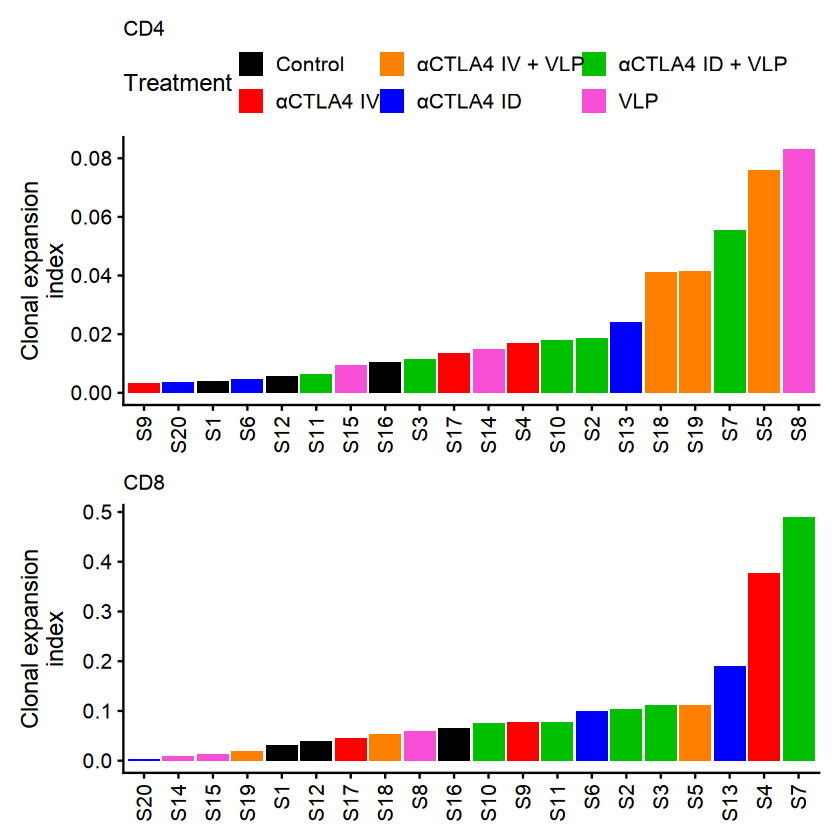

In [12]:
exp_ind_df <- tc_tcr@meta.data %>% filter(!is.na(CTaa)) %>%
    group_by(sample, treatment, aCTLA4, VLP, CDsubset, batch, CTaa, .drop=FALSE) %>% summarise(count=n()) %>%
    group_by(sample, treatment, aCTLA4, VLP, CDsubset, batch, .drop=FALSE) %>% mutate(freq_subset = count/sum(count), n_subset=n()) %>% 
    mutate(even_ind_i = freq_subset*log2(freq_subset)/log2(n_subset)) %>%
    summarise(exp_ind=1+sum(even_ind_i)) %>% filter(CDsubset!='else') %>%
    mutate(VLP=factor(VLP, levels=c('none','ID')), aCTLA4=factor(aCTLA4, levels=c('none','IV', 'ID'))) %>% filter(!is.nan(exp_ind))
expansion_cd8 <- ggplot(exp_ind_df %>% filter(CDsubset=='CD8'), aes(x=sample, y=exp_ind, fill=treatment)) + geom_col() +
    scale_x_discrete(limits=exp_ind_df %>% filter(CDsubset=='CD8') %>% arrange(exp_ind) %>% pull(sample)) +
    scale_fill_manual(values=c('black','red','#FF8000','blue','#00C000','#F74ED6')) +
    theme_cowplot() + labs(y='Clonal expansion\nindex', subtitle='CD8') + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), axis.title.x=element_blank(), legend.position='none')
expansion_cd4 <- ggplot(exp_ind_df %>% filter(CDsubset=='CD4'), aes(x=sample, y=exp_ind, fill=treatment)) + geom_col() +
    scale_x_discrete(limits=exp_ind_df %>% filter(CDsubset=='CD4') %>% arrange(exp_ind) %>% pull(sample)) +
    scale_fill_manual(values=c('black','red','#FF8000','blue','#00C000','#F74ED6')) +
    theme_cowplot() + labs(y='Clonal expansion\nindex', subtitle='CD4', fill='Treatment') + 
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), axis.title.x=element_blank(), legend.position='top')
expansion_cd4 / expansion_cd8 
ggsave('plot/b16_bar_tcr_expansion.pdf', width=6, height=5, device=cairo_pdf)

In [13]:
mean_exp_ind_df <- exp_ind_df %>% group_by(CDsubset, aCTLA4, VLP) %>% summarize(mean_ind = mean(exp_ind)) %>% 
    filter(CDsubset!='else') %>% dcast(VLP+aCTLA4~CDsubset)
col_ha <- rowAnnotation('VLP'= mean_exp_ind_df$VLP,'αCTLA4'= mean_exp_ind_df$aCTLA4,
                           col=list('VLP'=c('none'='cyan','ID'='purple'), 'αCTLA4'=c('none'='cyan','ID'='purple','IV'='dodgerblue')))
cairo_pdf('plot/b16_heat_expansion_ind.pdf', width=2.5, height=4)
Heatmap(mean_exp_ind_df[,3:4], name='Mean\nclonal\nexpansion\nindex', col = brewer.pal(5, 'YlOrRd'), rect_gp = gpar(col = "white", lwd = 5),
        cluster_columns = F, cluster_rows = F, left_annotation = col_ha)
dev.off()

Using mean_ind as value column: use value.var to override.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

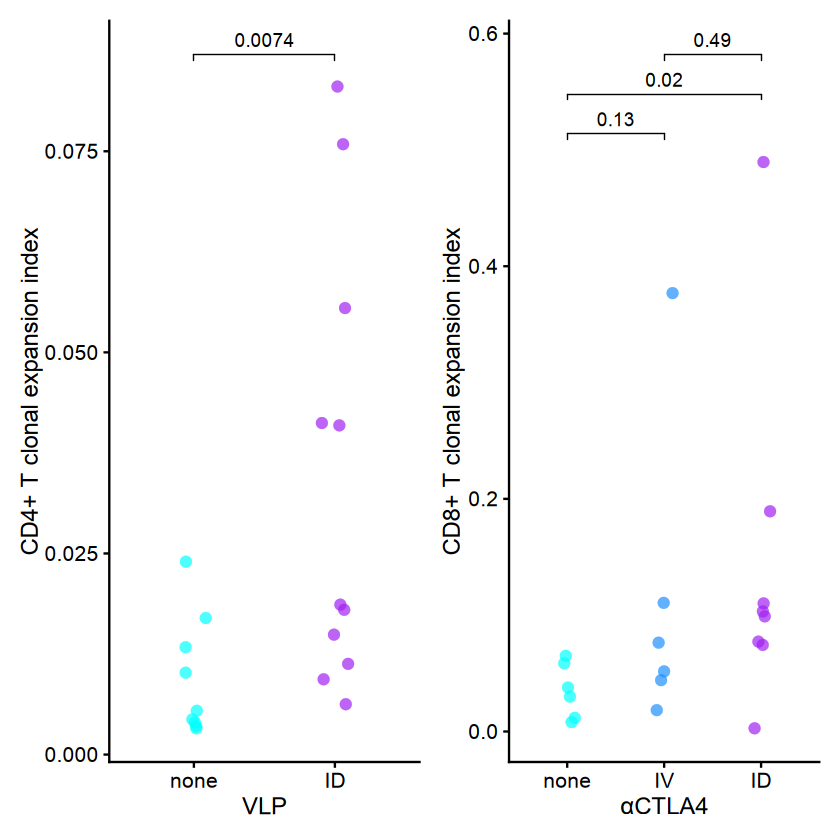

In [14]:
expansion_cd4 <- ggplot(exp_ind_df %>% filter(CDsubset=='CD4'), aes(x=VLP, y=exp_ind, color=VLP) ) + 
    geom_point(size=3, position=position_jitter(h=0, w=0.1), alpha = 0.7) +  
    stat_compare_means(comparisons = list(c('none', 'ID')), tip.length=0.01) +
    scale_color_manual(values=c('cyan','purple')) +
    theme_cowplot() + labs(x='VLP', y='CD4+ T clonal expansion index', color='Sample') +
    theme(legend.position='none')
expansion_cd8 <- ggplot(exp_ind_df %>% filter(CDsubset=='CD8'), aes(x=aCTLA4, y=exp_ind, color=aCTLA4) ) + 
    geom_point(size=3, position=position_jitter(h=0, w=0.1), alpha = 0.7) +  
    scale_color_manual(values=c('cyan','dodgerblue','purple')) +
    stat_compare_means(comparisons = list(c('none', 'IV'), c('none', 'ID'), c('IV', 'ID')), step.increase=0.07, tip.length=0.01) +
    theme_cowplot() + labs(x='αCTLA4', y='CD8+ T clonal expansion index', color='Sample') +
    theme(legend.position='none')
expansion_cd4 + expansion_cd8
ggsave('plot/b16_dot_expansion_treatment.pdf', width=6, height=4, device=cairo_pdf)

In [15]:
tc_tcr_n <- tc_tcr@meta.data %>% group_by(seurat_clusters) %>% summarise(ncell=n(),nclone=length(unique(CTaa)))
cloneSize_df <- tc_tcr@meta.data %>% 
    group_by(seurat_clusters, cloneSize, .drop=FALSE) %>% summarise(count=n()) %>% 
    ungroup() %>% group_by(seurat_clusters) %>% mutate(count_sample = sum(count)) %>% 
    mutate(ratio = count/count_sample, Percent=ratio*100) 
tcr_bycluster1 <- ggplot(tc_tcr_n, aes(x=seurat_clusters, y=ncell)) + geom_col(fill='deepskyblue', color='black') + labs(y='# T cells') +
    theme_cowplot() + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
                            axis.title.x=element_blank(), axis.line.x=element_blank())
tcr_bycluster2 <- ggplot(tc_tcr_n, aes(x=seurat_clusters, y=nclone)) + geom_col(fill='cadetblue', color='black') + labs(y='# clonotypes') +
    theme_cowplot() + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
                            axis.title.x=element_blank(), axis.line.x=element_blank())
tcr_bycluster3 <- ggplot(cloneSize_df, aes(y=Percent, x=seurat_clusters, fill=cloneSize)) + geom_col(color='black') + theme_cowplot() + 
    theme(axis.text.x=element_text(size=10)) + 
    scale_fill_manual(values=rev(brewer.pal(5, 'YlOrRd'))) + labs(y='Percentage', x='Cluster')

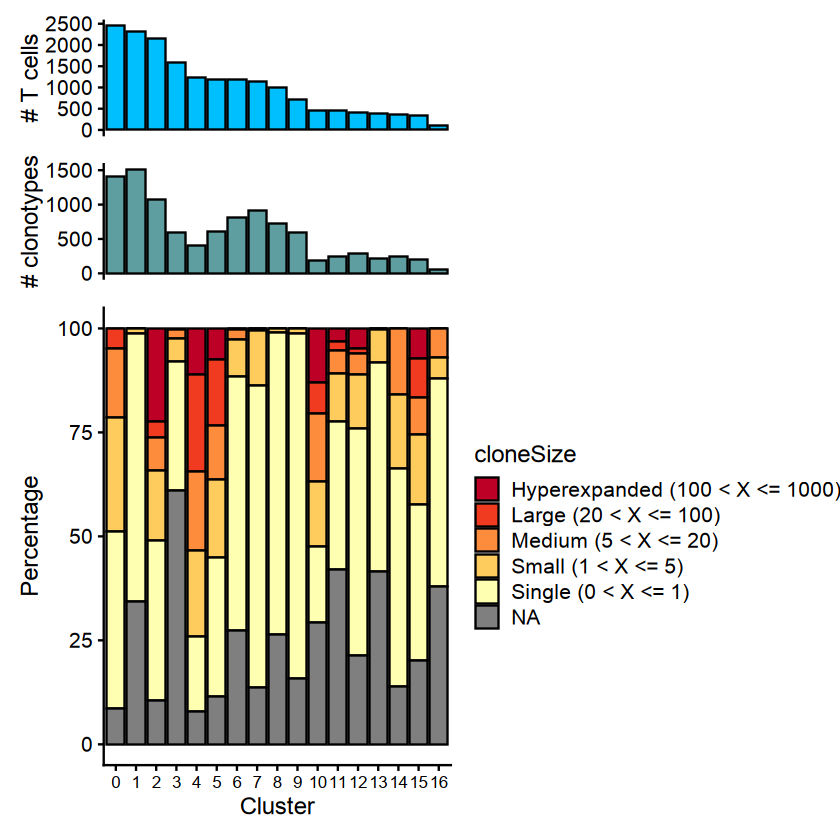

In [16]:
tcr_bycluster1 + tcr_bycluster2 + tcr_bycluster3 + plot_layout(ncol = 1, heights=c(1,1,4))
ggsave('plot/b16_tcr_stat_cluster.pdf', width=7, height=6, device=pdf)

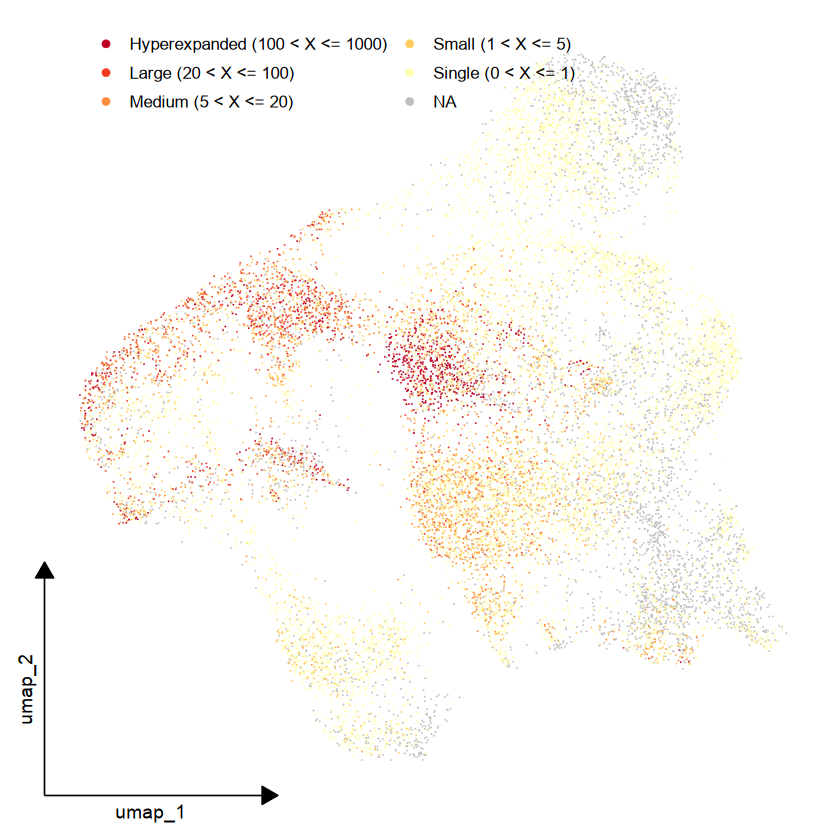

In [17]:
DimPlot(tc_tcr, group.by = "cloneSize") + 
    scale_color_manual(values=rev(brewer.pal(5, 'YlOrRd')), na.value='grey') + theme_dr() + 
    theme(panel.grid=element_blank(), plot.title = element_blank(),strip.background=element_blank(), legend.position=c(0.37,0.93),  
          strip.text=element_text(face='bold', size=13), legend.text=element_text(size=10)) + 
    guides(color = guide_legend(ncol = 2, override.aes = list(size=2)))
#ggsave('plot/b16_tcr_expansion.png', width=5, height=5, unit='in', dpi=100, bg='white')

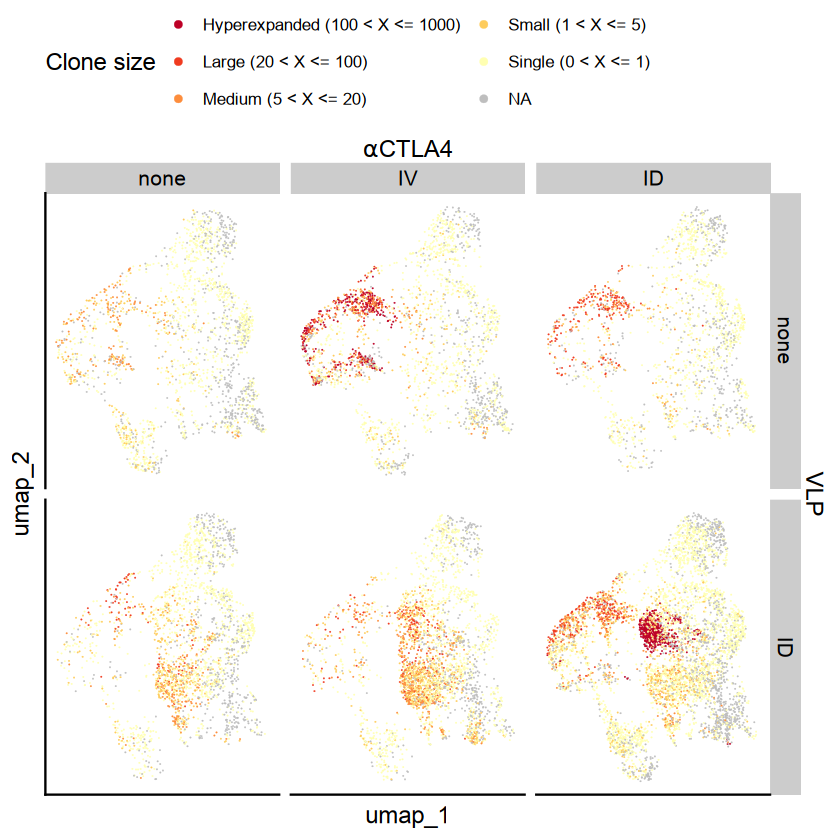

In [18]:
df_clonesize <- tc_tcr@meta.data %>%
    mutate(VLP=factor(VLP, levels=c('none','ID')), aCTLA4=factor(aCTLA4, levels=c('none','IV','ID')))
ggplot(df_clonesize, aes(x=umap_1, y=umap_2, color=cloneSize)) + geom_point(size=0.1) + facet_grid(VLP~aCTLA4) + 
    scale_color_manual(values=rev(brewer.pal(5, 'YlOrRd')), na.value='grey') +
    theme_cowplot() + theme(axis.text=element_blank(), axis.ticks=element_blank(), legend.position='top', legend.text=element_text(size=10))  +
    scale_y_continuous(sec.axis = sec_axis(~ . , name = "VLP", breaks = NULL, labels = NULL)) +
    scale_x_continuous(sec.axis = sec_axis(~ . , name = expression(alpha*"CTLA4"), breaks = NULL, labels = NULL)) + 
    guides(color = guide_legend(ncol = 2, override.aes = list(size=2))) +
    labs(color='Clone size')
ggsave('plot/b16_umap_expansion_by_treatment.pdf', width=8, height=6.8, device=pdf)

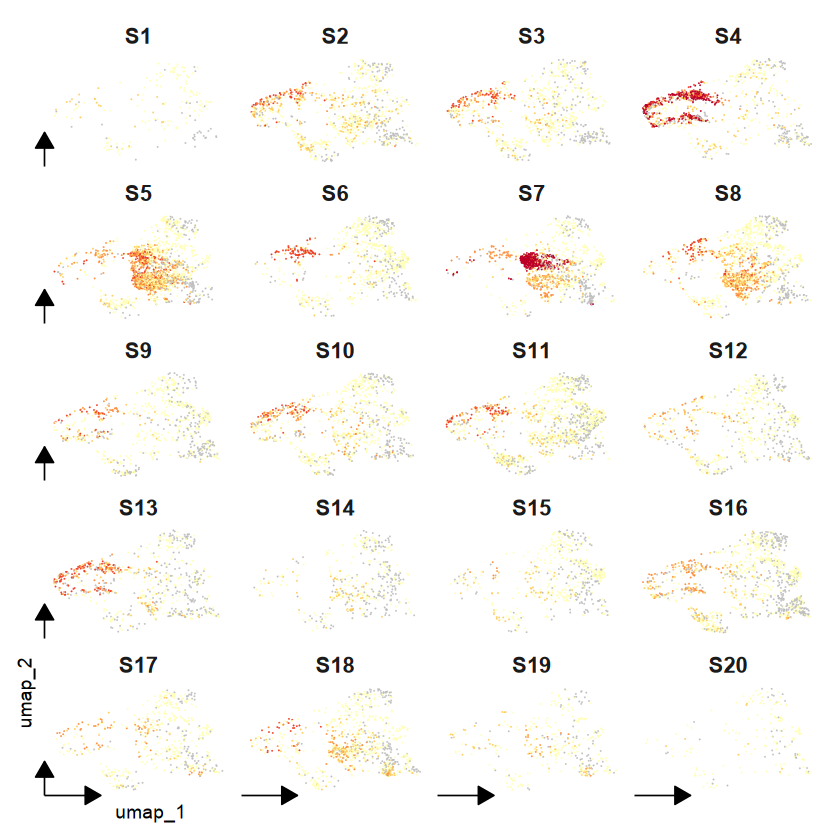

In [19]:
DimPlot(tc_tcr, group.by = "cloneSize", split.by='sample', ncol=4) + 
    scale_color_manual(values=rev(brewer.pal(5, 'YlOrRd')), na.value='grey') + theme_dr() + 
    theme(panel.grid=element_blank(), plot.title = element_blank(),strip.background=element_blank(), legend.position='none',  
          strip.text=element_text(face='bold', size=13), legend.text=element_text(size=10)) + 
    guides(color = guide_legend(ncol = 2, override.aes = list(size=2)))
ggsave('plot/b16_umap_expansion_sample.pdf', width=9, height=9)

Using Freq as value column: use value.var to override.



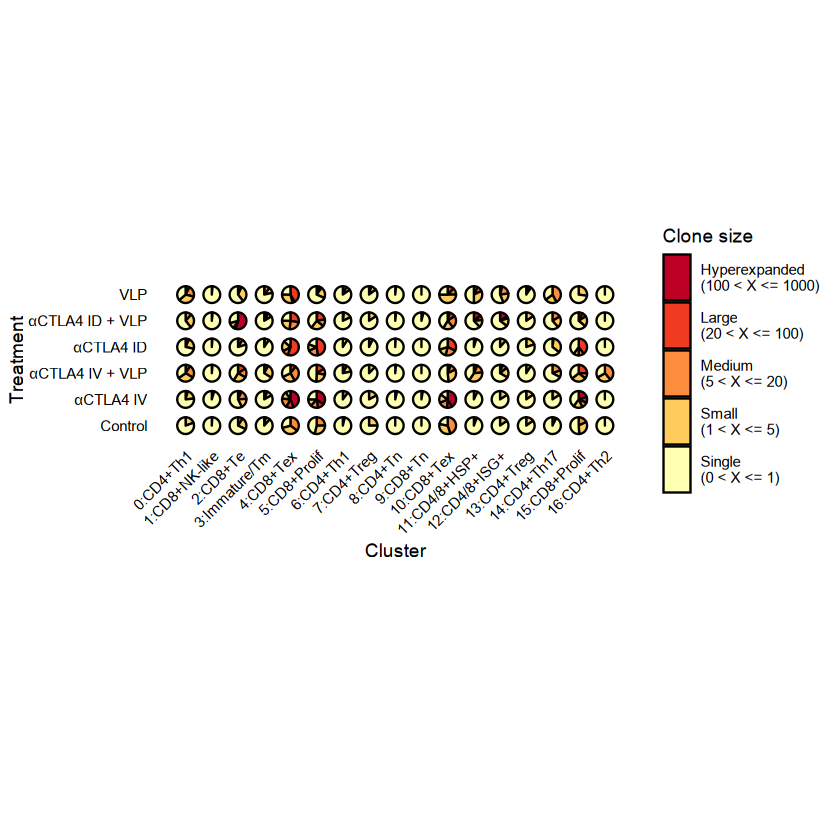

In [20]:
df_clonesize <- data.frame(xtabs(~ cluster_annotation + treatment + cloneSize, data = tc_tcr@meta.data)) %>% 
    dcast(cluster_annotation+treatment~cloneSize) %>% #mutate(cloneSize=str_replace(cloneSize, ' \\(','\n\\(')) %>% 
    mutate(int_x=as.integer(cluster_annotation), int_y=as.integer(treatment)) 
ggplot(df_clonesize, aes(y=int_y, x=int_x)) + 
    geom_scatterpie(aes(y=int_y, x=int_x), cols=colnames(df_clonesize)[3:7], data=df_clonesize ) +
    scale_x_continuous(breaks = 1:length(unique(df_clonesize$cluster_annotation)), 
                       labels = levels(df_clonesize$cluster_annotation), name = "Cluster") +
    scale_y_continuous(breaks = 1:6, labels = levels(df_clonesize$treatment), name = "Treatment") +
    scale_fill_manual(values=rev(brewer.pal(5, 'YlOrRd')), labels=str_replace(colnames(df_clonesize)[3:7], ' \\(','\n\\(')) + 
    coord_equal(clip = 'off') +
    labs(fill='Clone size') + theme_minimal() + 
    theme(axis.text=element_text(color='black'), axis.text.x=element_text(angle=45,hjust=1,vjust=1), 
          panel.grid=element_blank(), legend.key.height = unit(2, 'lines'))
ggsave('plot/b16_scatterpie_expansion.pdf', width=10, height=4, bg='white', device=cairo_pdf)

In [21]:
tc_tcr@meta.data %>% filter(clonalFrequency>1) %>% distinct(sample, CTaa, .keep_all = TRUE) %>% 
    mutate(cdr3b=str_trim(str_extract(CTaa, '(?<=_)([^;]*)'))) %>% filter(cdr3b!='NA') %>% select(sample, cdr3b) %>% group_by(sample) %>%
    mutate(order = row_number()) %>% ungroup() %>% mutate(fa_string=paste0('>',sample,'_trb',order,'\n',cdr3b)) %>%
    pull(fa_string) %>% write.table('csv/b16_expanded_trb.fa', quote=F, row.names=F, col.names = F)

pdf 
  2

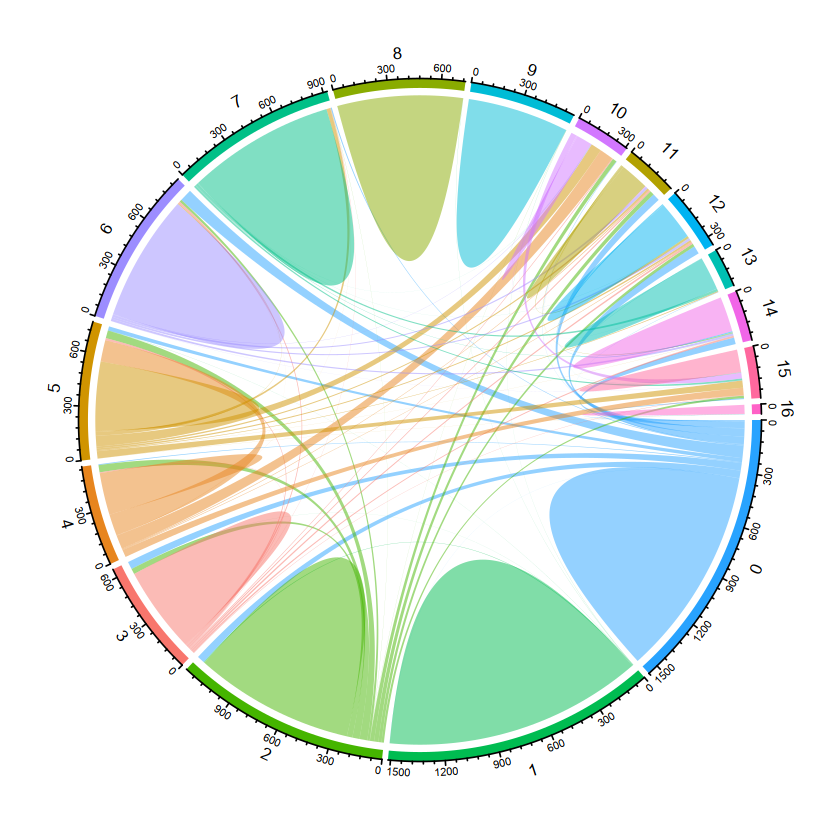

In [22]:
#Just assigning the normal colors to each cluster
grid.cols <- hue_pal()(length(unique(tc_tcr$seurat_clusters)))
names(grid.cols) <- unique(tc_tcr$seurat_clusters)
for(treatment_i in unique(tc_tcr$treatment))
{
    circles <- getCirclize(subset(tc_tcr, treatment==treatment_i), group.by = "seurat_clusters")
    pdf(paste0('plot/b16_chord_tcr_overlap_',treatment_i,'.pdf'), width=4, height=4)
    chordDiagram(circles, self.link = 1, grid.col = grid.cols)
    dev.off()
}


circles <- getCirclize(tc_tcr, group.by = "seurat_clusters")
#Graphing the chord diagram
chordDiagram(circles, self.link = 1, grid.col = grid.cols)
pdf(paste0('plot/b16_chord_tcr_overlap.pdf'), width=4, height=4)
chordDiagram(circles, self.link = 1, grid.col = grid.cols)
dev.off()


In [23]:
overlap_cluster <- clonalOverlap(tc_tcr, cloneCall = "aa", group.by='cluster_annotation', method="morisita", exportTable=T)
overlap_cluster[is.na(overlap_cluster)] <- 0
overlap_cluster <- overlap_cluster + t(overlap_cluster)
png('plot/b16_tcr_corr_cluster.pdf', height=4, width=4)
corrplot(as.matrix(overlap_cluster), method = 'circle', type = 'lower',number.cex = 0.8, is.corr=F, col.lim=c(0,1), # 
         diag = FALSE, col = COL1('Greens', 10))
dev.off()

Warning message in corrplot(as.matrix(overlap_cluster), method = "circle", type = "lower", :
“Not been able to calculate text margin, please try again with a clean new empty window using {plot.new(); dev.off()} or reduce tl.cex”


pdf 
  2

# PMTnet prediction for antigen-specific TCRs

In [24]:
netmhcpan2el_pred <- c('VLYRYGSFSLALD','VLYRYGSFSLALDI','VLYRYGSFSLALDIV','CVLYRYGSFSLALDI','CVLYRYGSFSLALD') # version 4.3
netmhcpan2ba_pred <- c('VLYRYGSFSLALDIVQ','CVLYRYGSFSLALDIV','DCVLYRYGSFSLALDI','LYRYGSFSLALDIVQG','LDCVLYRYGSFSLALD','PLDCVLYRYGSFSLALDIVQ',
                      'PLDCVLYRYGSFSLAL','LDCVLYRYGSFSLALDIVQG','VPLDCVLYRYGSFSLALDIV','DCVLYRYGSFSLALDIVQGI','QVPLDCVLYRYGSFSLALDI',
                       'VLYRYGSFSLALDIVQGIES','VLYRYGSFSLALDIVQG','CVLYRYGSFSLALDIVQGIE','CVLYRYGSFSLALDIVQ') # version 4.3 rank_ba<7
min_clonal_freq <- 2
df_pmtnet_cd8 <- tc_tcr@meta.data %>% 
    filter(clonalFrequency>=min_clonal_freq & str_detect(CTgene, 'TRAV') & str_detect(CTgene, 'TRBV') & CDsubset=='CD8') %>%
    mutate(va=str_extract(CTgene, '([^.+]*)'), cdr3a=str_extract(CTaa, '([^_]*)'), 
           vb=str_extract(CTgene, '(?<=_)([^.+]*)'), cdr3b=str_extract(CTaa, '(?<=_)([^_]*)'),
           peptide='VLYRYGSF', mhc='H-2-Kb',pMHC_SPECIES='mouse',TCR_SPECIES='mouse') %>% 
    distinct(CTaa, .keep_all = TRUE) %>% select(va, cdr3a, vb, cdr3b, peptide, mhc, pMHC_SPECIES, TCR_SPECIES)
df_pmtnet_cd4 <- tc_tcr@meta.data %>% 
    filter(clonalFrequency>=min_clonal_freq & str_detect(CTgene, 'TRAV') & str_detect(CTgene, 'TRBV') & CDsubset=='CD4') %>%
    mutate(va=str_extract(CTgene, '([^.+]*)'), cdr3a=str_extract(CTaa, '([^_]*)'), 
           vb=str_extract(CTgene, '(?<=_)([^.+]*)'), cdr3b=str_extract(CTaa, '(?<=_)([^_]*)'),
           peptide='VLYRYGSFSLAL', mhc='H-2-IAb',pMHC_SPECIES='mouse',TCR_SPECIES='mouse') %>% 
    distinct(CTaa, .keep_all = TRUE) %>% select(va, cdr3a, vb, cdr3b, peptide, mhc, pMHC_SPECIES, TCR_SPECIES)
df_pmtnet_cd4_all <- NULL
for(peptide_i in netmhcpan2el_pred)
{
    df_pmtnet_cd4_all <- rbind(df_pmtnet_cd4_all, df_pmtnet_cd4 %>% mutate(peptide=peptide_i))
}
for(peptide_i in netmhcpan2ba_pred)
{
    df_pmtnet_cd4_all <- rbind(df_pmtnet_cd4_all, df_pmtnet_cd4 %>% mutate(peptide=peptide_i))
}
df_pmtnet <- rbind(df_pmtnet_cd8, df_pmtnet_cd4_all)
dim(df_pmtnet)

[1] 9648    8

In [25]:
# split dual-TCR sequences
df_pmtnet <- split_duel_tcr(df_pmtnet) 
df_pmtnet <- tcr_gene2allele(df_pmtnet)
dim(df_pmtnet)

[1] 10541     8

In [26]:
write.csv(df_pmtnet, 'csv/pmtnet_input_20240917.csv', row.names=F, quote=F)
write.csv(df_pmtnet %>% filter(mhc=='H-2-Kb'), 'csv/pmtnet_input_20240917_mhc1.csv', row.names=F, quote=F)
write.csv(df_pmtnet %>% filter(mhc=='H-2-IAb'), 'csv/pmtnet_input_20240917_mhc2_20epitopes.csv', row.names=F, quote=F)
write.csv(df_pmtnet %>% filter(mhc=='H-2-IAb' & peptide %in% c(netmhcpan2el_pred[1:3], netmhcpan2ba_pred[1:3])), 
          'csv/pmtnet_input_20240917_mhc2_top3.csv', row.names=F, quote=F)
write.csv(df_pmtnet %>% filter(mhc=='H-2-IAb' & peptide %in% c(netmhcpan2el_pred[4:5], netmhcpan2ba_pred[4:5])), 
          'csv/pmtnet_input_20240917_mhc2_4to5.csv', row.names=F, quote=F)
head(df_pmtnet)

va           cdr3a        vb          cdr3b         
S5_AAAGTAGCATGTCCTC-14  TRAV10*02    CAAADSNYQLIW TRBV12-2*01 CASSLDGANSDYTF
S7_ACTTTCACAATTGCTG-14  TRAV10*02    CAAADSNYQLIW TRBV12-2*01 CASSWDGANSDYTF
S18_CGAGCCAAGGATATAC-14 TRAV14N-3*01 CAAAGDNSKLIW TRBV31*01   CAWSLGGNYAEQFF
S16_CACAGTAGTACGCTGC-14 TRAV19*03    CAAAGGNNKLTF TRBV15*01   CASSPSQNTLYF  
S5_AGGGAGTAGATAGTCA-14  TRAV7D-2*02  CAAANSGTYQRF TRBV12-2*01 CASGEGARGEQYF 
S18_TACTTACGTCGCGAAA-14 TRAV10*02    CAAANSNYQLIW TRBV12-2*01 CASGEGRNTEVFF 
                        peptide        mhc     pMHC_SPECIES TCR_SPECIES
S5_AAAGTAGCATGTCCTC-14  CVLYRYGSFSLALD H-2-IAb mouse        mouse      
S7_ACTTTCACAATTGCTG-14  CVLYRYGSFSLALD H-2-IAb mouse        mouse      
S18_CGAGCCAAGGATATAC-14 CVLYRYGSFSLALD H-2-IAb mouse        mouse      
S16_CACAGTAGTACGCTGC-14 CVLYRYGSFSLALD H-2-IAb mouse        mouse      
S5_AGGGAGTAGATAGTCA-14  CVLYRYGSFSLALD H-2-IAb mouse        mouse      
S18_TACTTACGTCGCGAAA-14 CVLYRYGSFSLALD H-2-IAb mouse        mouse

In [27]:
tc_tcr@meta.data %>% 
    filter(clonalFrequency>=10 & str_detect(CTgene, 'TRAV') & str_detect(CTgene, 'TRBV') ) %>%
    mutate(cdr3a=str_extract(CTaa, '([^_]*)'), cdr3b=str_extract(CTaa, '(?<=_)([^_]*)'),
          peptide='VLYRYGSF', mhc='H-2-Kb') %>% distinct(cdr3b, .keep_all = TRUE) %>% head(50) %>%
    split_duel_tcr() %>% group_by(orig.ident) %>% top_n(2, wt=clonalFrequency) %>% select(cdr3b, orig.ident, clonalFrequency) %>% 
    arrange(orig.ident) %>% write.csv('csv/b16_top_expanded_trb.csv', row.names=F)

In [28]:
df_pmtnet_mhc2 <- df_pmtnet %>% filter(mhc=='H-2-IAb') 
for(i in 1:nrow(df_pmtnet_mhc2))
{
    if(i %% 490 == 0)
    {
        write.csv(df_pmtnet_mhc2[(i-489):i,], paste0('csv/pmtnet_input_20240917_mhc2_p',i %/% 490,'.csv'), row.names=F, quote=F)
    }
}
write.csv(df_pmtnet_mhc2[(i %/% 490 * 490 + 1):i,], paste0('csv/pmtnet_input_20240917_mhc2_p',i %/% 490 + 1,'.csv'), row.names=F, quote=F)

### read pmtnet prediction

In [29]:
# read pmtnet prediction
pmtnet_pred_cd8 <- read.csv('csv/pMTnet_20240917_mhc1_prediction.csv')
pmtnet_pred_cd4 <- read.csv('csv/pMTnet_20240917_mhc2_prediction.csv')
pmtnet_pred_cd4_extend <- read.csv('csv/pMTnet_20240917_mhc2_prediction_extend.csv')
pmtnet_pred_cd4 <- rbind(pmtnet_pred_cd4, pmtnet_pred_cd4_extend)
# find the peptide with highest binding with TCR 
pmtnet_pred_cd4 <- pmtnet_pred_cd4 %>% mutate(cdr3=paste(cdr3a, cdr3b, mhc)) %>% split(.$cdr3) %>% 
    lapply(function(x) x[which.min(x$percentile_rank_0),]) %>% bind_rows() %>% select(-cdr3)
pmtnet_pred <- rbind(pmtnet_pred_cd8, pmtnet_pred_cd4)
dim(pmtnet_pred)

[1] 1009   26

In [30]:
tc_tcr <- assign_percentile_logit(tc_tcr, pmtnet_out_cd8=pmtnet_pred_cd8, pmtnet_out_cd4=pmtnet_pred_cd4, antigen='pmel')
tc_tcr$specificity <- ifelse(tc_tcr$percentile_pmel<0.03, 'specific' ,'non-specific')
tc_tcr$specificity[is.na(tc_tcr$specificity)] <- 'non-determined'
table(tc_tcr$specificity)


non-determined   non-specific       specific 
         12927           4447             73 

In [31]:
saveRDS(tc_tcr, 'data/b16_tc_tcr_5batch.rds')

Warning message:
“Removed 12927 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 12927 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 12927 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 12927 rows containing non-finite outside the scale range (`stat_bin()`).”


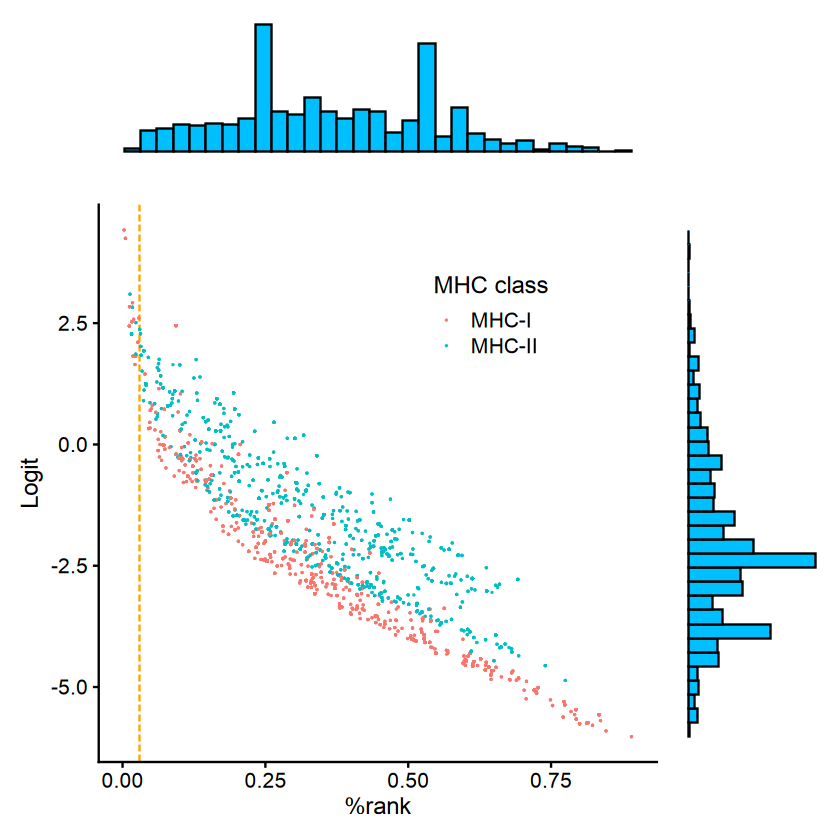

In [32]:
dotplot <- ggplot(tc_tcr@meta.data %>% filter(!is.na(MHC)), aes(x = percentile_pmel, y = logit_pmel, color=MHC)) + 
  geom_vline(xintercept=0.03, linetype='longdash', color='orange') + labs(x='%rank', y='Logit', color='MHC class') +
  geom_point(size=0.5) +  theme_cowplot() + theme(legend.position=c(0.6,0.8))

histogram_x <- ggplot(tc_tcr@meta.data, aes(x = percentile_pmel)) +
  geom_histogram(binwidth = 0.03, fill = "deepskyblue", color = "black") +  # Customize histogram appearance
  theme_minimal() +  labs(x='') + 
  theme(axis.title.y=element_blank(), axis.text=element_blank(), axis.ticks.y=element_blank(), panel.grid=element_blank()) 

histogram_y <- ggplot(tc_tcr@meta.data, aes(x = logit_pmel)) +
  geom_histogram(binwidth = 0.3, fill = "deepskyblue", color = "black") +  # Customize histogram appearance
  theme_minimal() +  # Apply a minimal theme (optional)
  coord_flip() +  labs(y='')+
  theme(axis.title.y=element_blank(), axis.text=element_blank(), axis.ticks.y=element_blank(), panel.grid=element_blank())  

histogram_x + plot_spacer() + dotplot + histogram_y  + plot_layout(widths = c(4, 1), heights= c(1, 4))
ggsave('plot/b16_scatter_percentile_logit.pdf', width=4, height=4, device=pdf)

In [33]:
pmtnet_pred %>%
    write.csv('csv/b16_pmel_specificity_prediction_by_clonotype.csv', row.names=T)
tc_tcr@meta.data %>% filter(!is.na(CTaa) & !is.na(percentile_pmel))  %>% 
    select(sample, treatment, cluster_annotation, CTgene, CTaa, clonalFrequency, percentile_pmel, specificity, MHC) %>%
    write.csv('csv/b16_pmel_specificity_prediction_by_cell.csv', row.names=T)

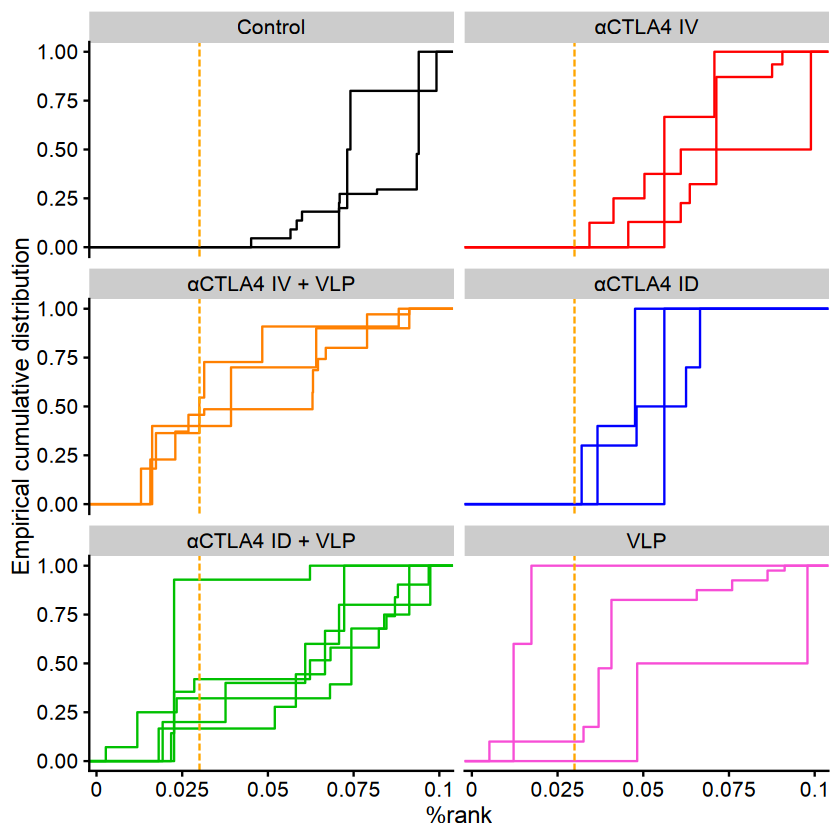

In [34]:
ggplot(tc_tcr@meta.data %>% filter(percentile_pmel<=0.1),aes(x=percentile_pmel, group=orig.ident, color=treatment)) + stat_ecdf(geom = "step") + 
    theme_cowplot() + labs(x='%rank', y='Empirical cumulative distribution', color='Treatment') +
    theme(legend.key.height=unit(2.2,'lines'), legend.position='none') + facet_wrap(~treatment, ncol=2) +
    geom_vline(xintercept=0.03, linetype='longdash', color='orange') +
    scale_color_manual(values=c('black','red','#FF8000','blue','#00C000','#F74ED6')) +
    scale_x_continuous(labels = function(x) sprintf("%g", x))
ggsave('plot/b16_ecdf_antigen_specific_by_treatment.pdf', width=6, height=6, device=cairo_pdf)

Warning message:
“Removed 17121 rows containing non-finite outside the scale range (`stat_ecdf()`).”
Warning message:
“Removed 17121 rows containing non-finite outside the scale range (`stat_ecdf()`).”


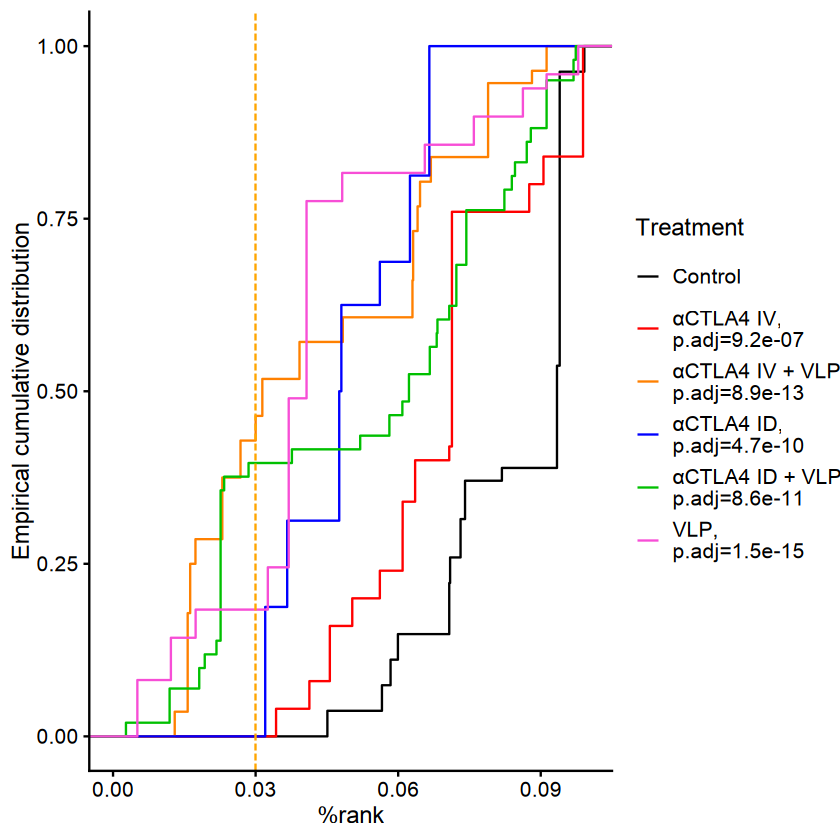

In [35]:
treatments <- c('αCTLA4 IV','αCTLA4 IV + VLP','αCTLA4 ID','αCTLA4 ID + VLP','VLP')
ksp <- c()
for(treatment_i in treatments)
{
    ksp <- c(ksp, tc_tcr@meta.data %>% filter(percentile_pmel<0.1, treatment %in% c('Control', treatment_i)) %>% 
             ks.test(percentile_pmel~treatment, data=.) %>% .$p.value)
}
ksp <- signif(p.adjust(ksp, method='BH'),2)
ggplot(tc_tcr@meta.data,aes(x=percentile_pmel, color=treatment)) + stat_ecdf(geom = "step") + 
    scale_x_continuous(breaks=c(0,0.03,0.06,0.09), limits=c(0,0.1)) +
    theme_cowplot() + labs(x='%rank', y='Empirical cumulative distribution', color='Treatment') +
    geom_vline(xintercept=0.03, linetype='longdash', color='orange') +
    scale_color_manual(labels=c('Control',paste0(treatments, ',\np.adj=', ksp)), values=c('black','red','#FF8000','blue','#00C000','#F74ED6')) +
    theme(legend.key.height=unit(2.2,'lines')) 
ggsave('plot/b16_ecdf_antigen_specific.pdf', width=5.5, height=4, device=cairo_pdf)

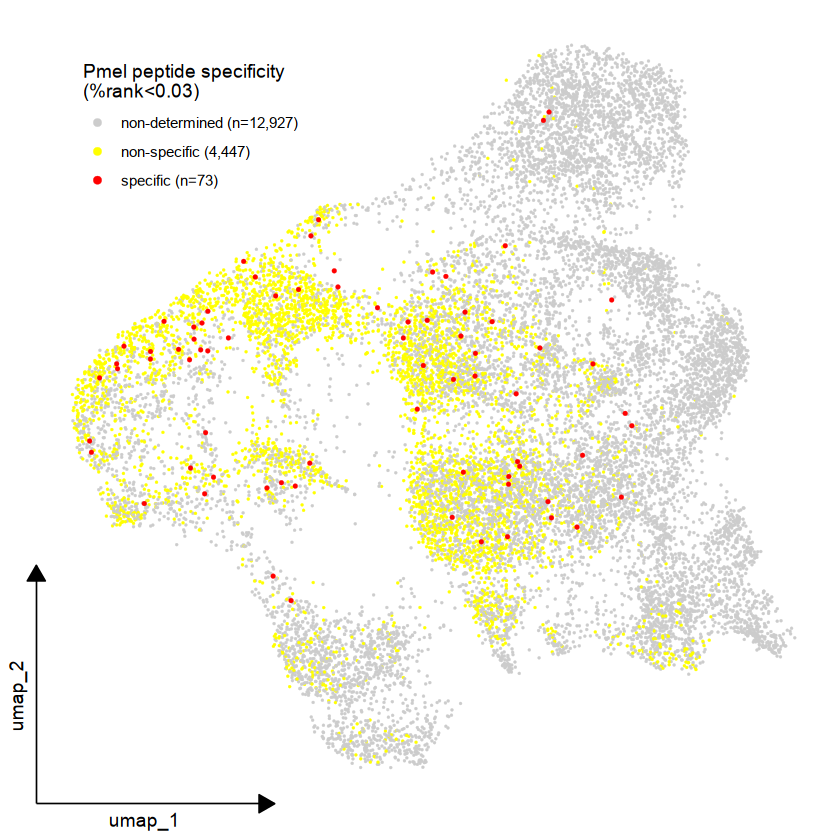

In [36]:
ggplot(tc_tcr@meta.data, aes(x=umap_1, y=umap_2, color=specificity)) + 
    geom_point(size=0.5) + 
    scale_color_manual(values=c('gray80','yellow','red'), labels=c('non-determined (n=12,927)','non-specific (4,447)','specific (n=73)')) +
    geom_point(data = tc_tcr@meta.data %>% filter(specificity=='specific'), size=1, color='red') +
    theme_dr() + theme(panel.grid=element_blank(), legend.position=c(0.2,0.85)) + 
    guides(color = guide_legend(override.aes = list(size = 2) ) ) +
    labs(color='Pmel peptide specificity\n(%rank<0.03)')
ggsave('plot/b16_umap_tcr_specific.pdf', width=4, height=4, device=pdf)

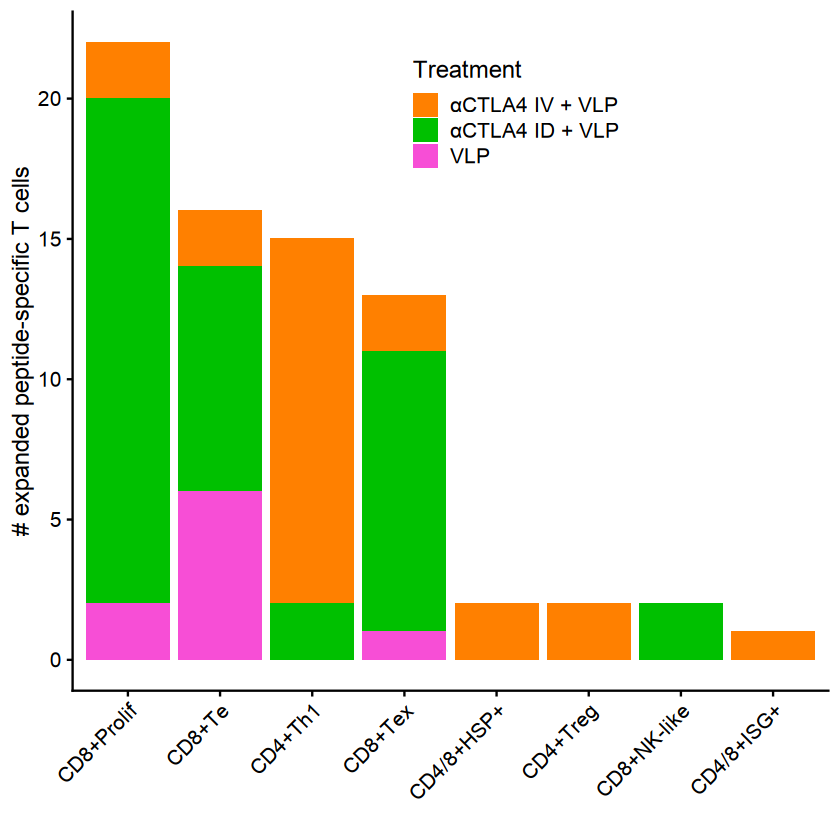

In [37]:
df_specific_annotation <- tc_tcr@meta.data %>% group_by(annotation, treatment) %>% 
    summarize(count=sum(specificity == 'specific', na.rm=T)) %>% filter(count>0)
ggplot(df_specific_annotation, aes(x=annotation, y=count, fill=treatment)) + 
    geom_col() + theme_cowplot() + labs(x='', y='# expanded peptide-specific T cells', fill='Treatment') + 
    scale_x_discrete(limits=df_specific_annotation %>% group_by(annotation) %>% summarize(count=sum(count)) %>% 
                     arrange(count) %>% pull(annotation) %>% rev()) + 
    scale_fill_manual(values=c('#FF8000','#00C000','#F74ED6')) +
    theme(legend.position=c(0.45,0.85), axis.text.x=element_text(angle=45, hjust=1, vjust=1))
ggsave('plot/b16_bar_antigen_specific_by_annotation.pdf', width=4, height=4, device=cairo_pdf)

In [38]:
cd8t_tcr <- subset(tc_tcr, CDsubset == 'CD8' & !is.na(tc_tcr$cloneSize))
cd8t_tcr

An object of class Seurat 
32285 features across 6860 samples within 1 assay 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

In [39]:
cd4t_tcr <- subset(tc_tcr, CDsubset == 'CD4' & !is.na(tc_tcr$cloneSize))
cd4t_tcr

An object of class Seurat 
32285 features across 5702 samples within 1 assay 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Removed 12927 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 12927 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 12927 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message:
“Removed 12927 rows containing missing values or values outside the scale range (`geom_point()`).”


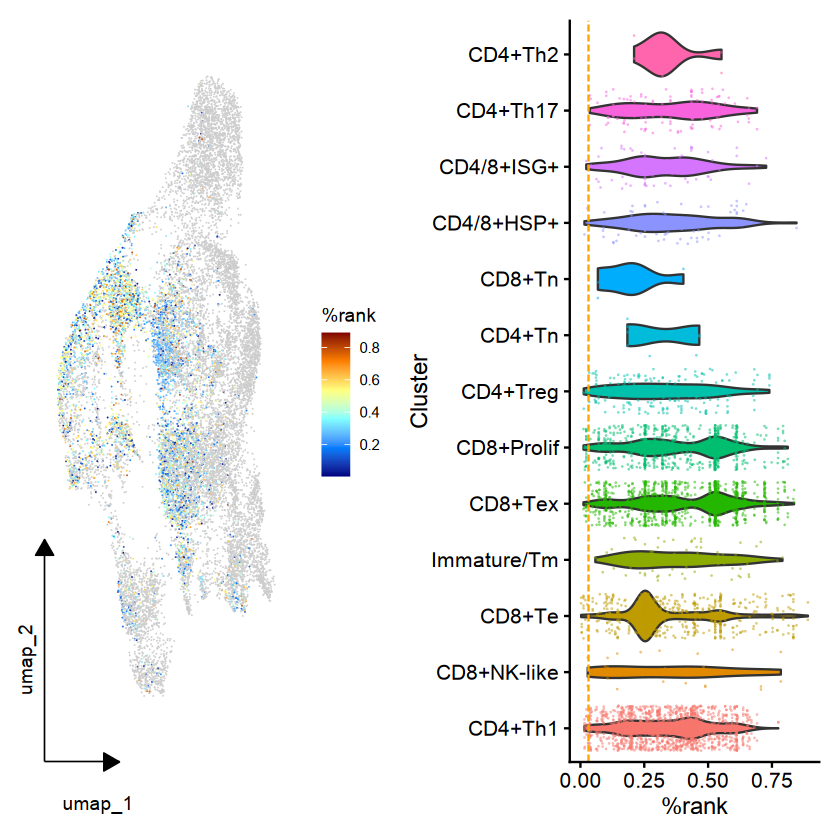

In [40]:
FeaturePlot(tc_tcr, c('percentile_pmel')) + labs(color='%rank') +
    scale_color_gradientn(colors=colorRamps::matlab.like(6), na.value="gray80") + 
    theme_dr() + theme(panel.grid=element_blank(), plot.title=element_blank()) |
ggplot(tc_tcr@meta.data, aes(y=annotation, x=percentile_pmel, fill=annotation)) + 
    geom_violin() + geom_jitter(aes(color=annotation), size=0.3, alpha=0.5) + 
    geom_vline(xintercept=0.03, linetype='longdash', color='orange') +
    theme_cowplot() + theme(legend.position='none') + labs(x='%rank',y='Cluster')
ggsave('plot/b16_percentile_by_cluster.pdf', width=8, height=4, device=pdf)

In [41]:
# PMID: 35113651
neoTCR <- read.csv('csv/neoTCR.csv')
neoTCR4 <- str_to_title(neoTCR[,1])
neoTCR4 <- neoTCR4[neoTCR4 %in% rownames(tc)]
neoTCR8 <- str_to_title(neoTCR[,2])
neoTCR8 <- neoTCR8[neoTCR8 %in% rownames(tc)]
TR30 <- str_to_title(c('GZMB','GZMH','NKG7','CCL5','HAVCR2','GZMA','CTLA4','CXCR6','VCAM1','GAPDH',
          'LSP1','CD38','ACTB','LAG3','DUSP4','FKPB1A','IFNG','CXCL13',
          'CD52','PRF1','LYST','CTSD','CD74','CHST12','LY6E','SNAP47','ACP5','GALNT2')) # Fig S6. PMID: 37967201
TR30 <- TR30[TR30 %in% rownames(tc)]
cd8t_tcr <- AddModuleScore_UCell(cd8t_tcr, features = list('neoTCR4'=neoTCR4, 'neoTCR8'=neoTCR8, 'TR30'=TR30))
cd8t_df <- FetchData(cd8t_tcr[,cd8t_tcr$specificity %in% c('specific','non-specific')], c('specificity','Cxcl13','Entpd1','neoTCR8_UCell','TR30_UCell'))
roc_TR30 <- roc(cd8t_df$specificity, cd8t_df$TR30_UCell)
roc_neoTCR8 <- roc(cd8t_df$specificity, cd8t_df$neoTCR8_UCell)
roc_cxcl13 <- roc(cd8t_df$specificity, cd8t_df$Cxcl13)
roc_cd39 <- roc(cd8t_df$specificity, cd8t_df$Entpd1)

Setting levels: control = non-specific, case = specific

Setting direction: controls > cases

Setting levels: control = non-specific, case = specific

Setting direction: controls > cases

Setting levels: control = non-specific, case = specific

Setting direction: controls < cases

Setting levels: control = non-specific, case = specific

Setting direction: controls < cases



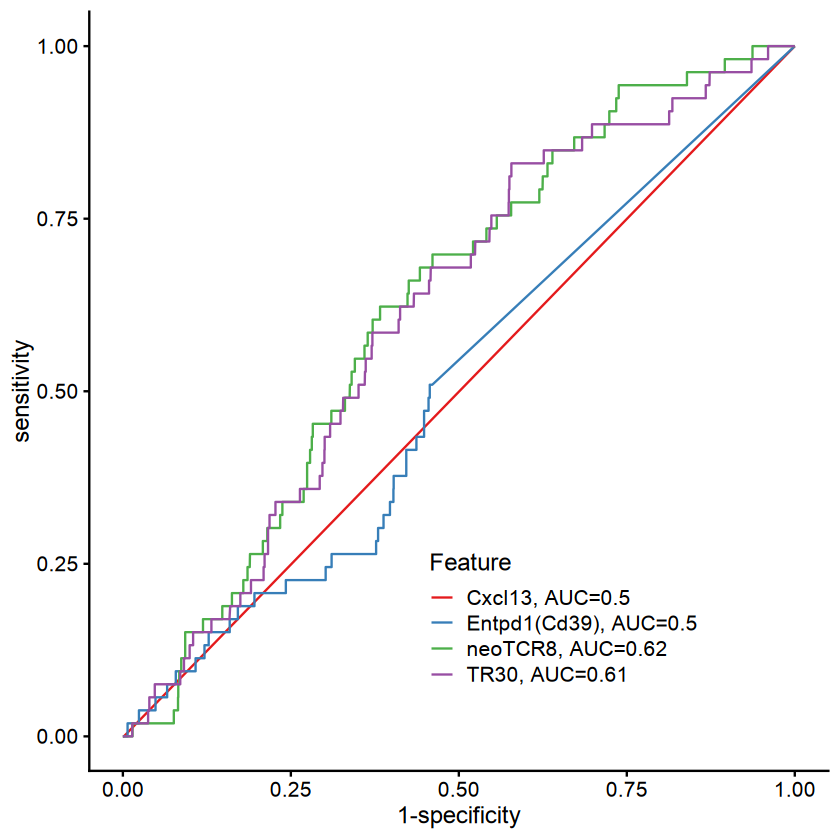

In [42]:
ggroc(list(Cxcl13=roc_cxcl13, Cd39=roc_cd39, neoTCR8=roc_neoTCR8, TR30=roc_TR30), legacy.axes=T) +
    theme_cowplot() + labs(color='Feature') + theme(legend.position=c(0.46,0.2)) + 
    scale_color_manual(labels=c(paste('Cxcl13, AUC=',round(auc(roc_cxcl13),2),sep=''),
                                  paste('Entpd1(Cd39), AUC=',round(auc(roc_cd39),2),sep=''),
                                  paste('neoTCR8, AUC=',round(auc(roc_neoTCR8),2),sep=''),
                                  paste('TR30, AUC=',round(auc(roc_TR30),2),sep='')),
                        values=brewer.pal(4,'Set1'))
ggsave('plot/b16_roc_specific_markers.pdf', width=4, height=4, device=pdf)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


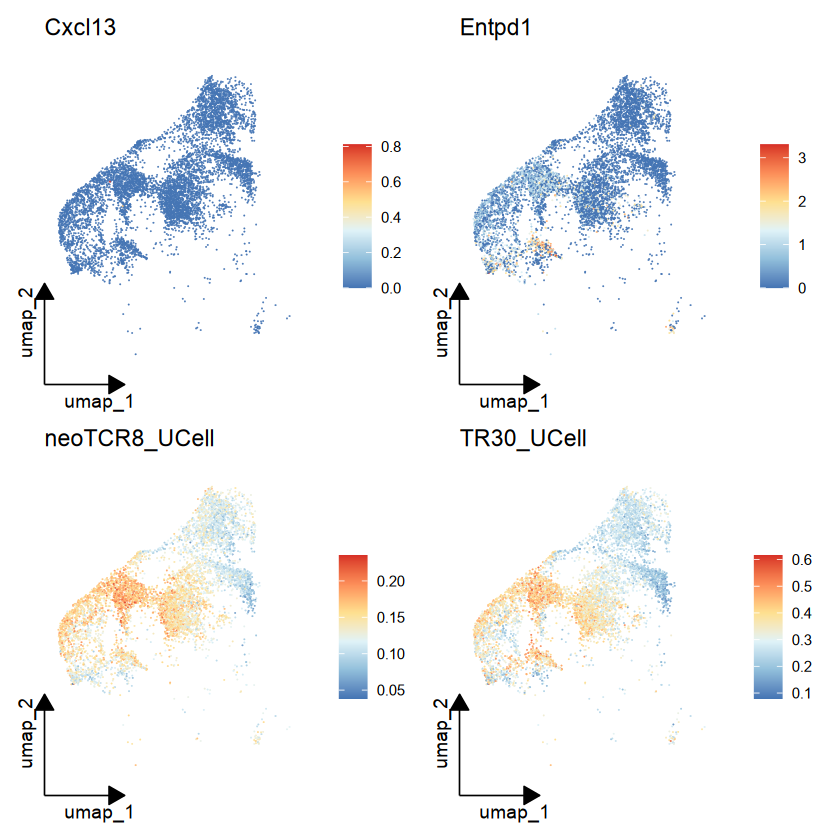

In [43]:
# PMID: 35452604
fp_reactive <- FeaturePlot(cd8t_tcr, c('Cxcl13','Entpd1','neoTCR8_UCell','TR30_UCell'), pt.size=0.1) & 
    scale_color_gradientn(colors=rev(brewer.pal(6,'RdYlBu'))) & theme_dr() & theme(panel.grid=element_blank())

fp_reactive 
ggsave('plot/b16_umap_specific_markers.pdf', width=7, height=7, device=pdf)

In [44]:
thred <- 0.03
pos <- position_jitter(width = 0.1, seed = 2)
specific_ratio_df <- cd8t_tcr@meta.data %>% group_by(sample, treatment, VLP) %>% 
    summarise(specific_ratio = sum(percentile_pmel<thred, na.rm=T)/length(percentile_pmel))
n_clonotype_df <- cd8t_tcr@meta.data %>% group_by(sample,treatment, VLP) %>% filter(percentile_pmel<thred & clonalFrequency>1) %>%
    summarise(n_clonotype=length(unique(percentile_pmel)))
specific_df_cd8 <- merge(specific_ratio_df, n_clonotype_df, common_column = 'sample', all=T)
specific_df_cd8$n_clonotype[is.na(specific_df_cd8$n_clonotype)] <- 0
scatter_specific_cd8 <- ggplot(specific_df_cd8, aes(x=as.character(n_clonotype), y=specific_ratio*100, color=treatment, shape=VLP)) + 
    geom_point(size=4, position=pos, alpha = 0.7) + 
    scale_color_manual(values=c('black','red','#FF8000','blue','#00C000','#F74ED6')) +
    geom_text_repel(aes(label=sample), force=10, position=pos) + guides(color="none") +
    theme_bw() + labs(x='# clonotype', y='Percentage in CD8+ T cells', color='Sample', title='Clonally expanded peptide-\nspecific CD8+ T cell') +
    theme(legend.position='none')
#write.csv(specific_df_cd8, 'csv/specific_percentage_sample_cd8.csv', quote=T, row.names=F)

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


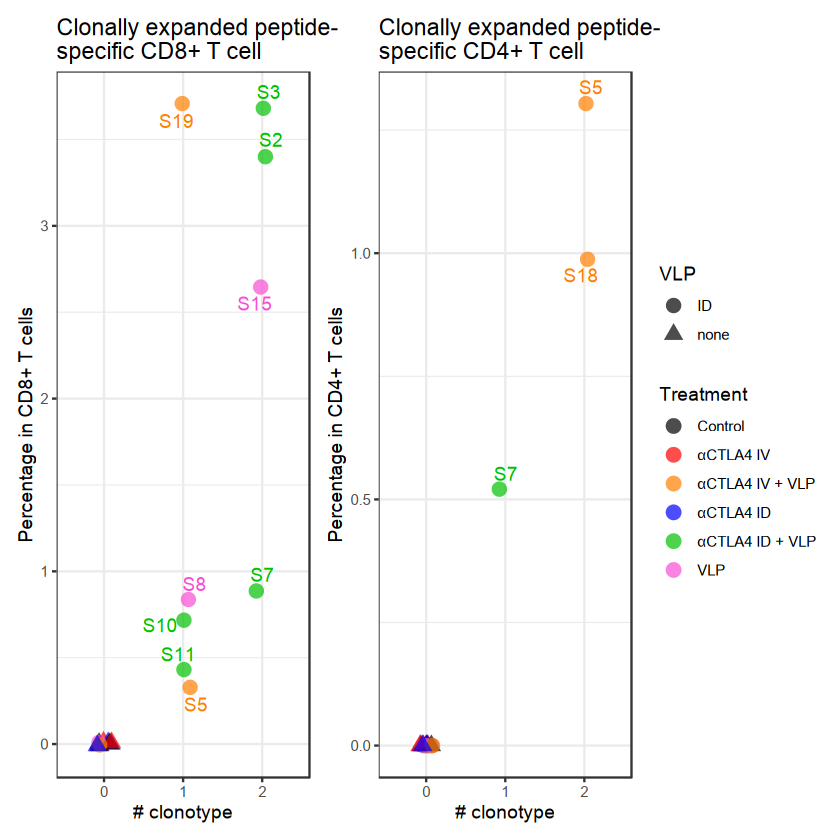

In [45]:
thred <- 0.03
pos <- position_jitter(width = 0.1, height=0, seed = 3)
specific_ratio_df <- cd4t_tcr@meta.data %>% group_by(sample, treatment, VLP) %>% 
    summarise(specific_ratio = sum(percentile_pmel<thred, na.rm=T)/length(percentile_pmel))
n_clonotype_df <- cd4t_tcr@meta.data %>% group_by(sample,treatment, VLP) %>% filter(percentile_pmel<thred) %>%
    summarise(n_clonotype=length(unique(percentile_pmel)))
specific_df_cd4 <- merge(specific_ratio_df, n_clonotype_df, common_column = 'sample', all=T)
specific_df_cd4$n_clonotype[is.na(specific_df_cd4$n_clonotype)] <- 0
scatter_specific_cd4 <- ggplot(specific_df_cd4, aes(x=as.character(n_clonotype), y=specific_ratio*100, color=treatment, shape=VLP)) + 
    geom_point(size=4, position=pos, alpha = 0.7) + 
    geom_text_repel(aes(label=sample), force=10, position=pos, show.legend = FALSE) + #guides(color="none") +
    scale_color_manual(values=c('black','red','#FF8000','blue','#00C000','#F74ED6')) +
    theme_bw() + labs(x='# clonotype', y='Percentage in CD4+ T cells', color='Treatment', title='Clonally expanded peptide-\nspecific CD4+ T cell') +
    theme(legend.position='right')
scatter_specific_cd8 + scatter_specific_cd4
ggsave('plot/b16_antigen_specific_percentage.pdf', width=6.2, height=3.5, unit='in', device=cairo_pdf)

In [46]:
specific_sample_cd8 <- specific_df_cd8 %>% group_by(VLP) %>% 
    summarize(specific_detected=sum(specific_ratio>0), specific_absent=sum(specific_ratio==0))
specific_sample_cd8
fisher.test(specific_sample_cd8[,-1])

VLP  specific_detected specific_absent
1 ID   9                 2              
2 none 0                 9


	Fisher's Exact Test for Count Data

data:  specific_sample_cd8[, -1]
p-value = 0.0003334
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.879719      Inf
sample estimates:
odds ratio 
       Inf 


In [47]:
specific_sample_cd4 <- specific_df_cd4 %>% group_by(VLP) %>% 
    summarize(specific_detected=sum(specific_ratio>0), specific_absent=sum(specific_ratio==0))
specific_sample_cd4
fisher.test(specific_sample_cd4[,-1])

VLP  specific_detected specific_absent
1 ID   3                 8              
2 none 0                 9


	Fisher's Exact Test for Count Data

data:  specific_sample_cd4[, -1]
p-value = 0.2184
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3544434       Inf
sample estimates:
odds ratio 
       Inf 


ggplot(specific_df_cd4, aes(x=VLP, y=specific_ratio*100, color=VLP)) + 
    geom_point(size=5, position=position_jitter(h=0, w=0.1), alpha = 0.7) +  stat_compare_means(label='p', label.x = 1.5) +
    theme_cowplot() + labs(x='VLP', y='CD4+ antigen-specific T cell percentage', color='Sample') +
    theme(legend.position='none')

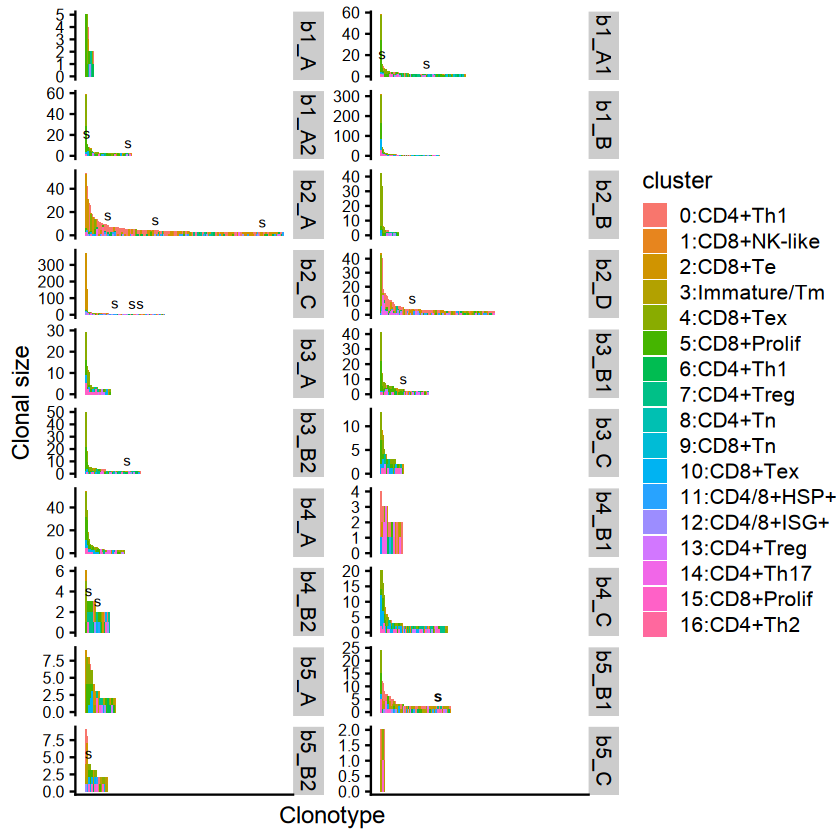

In [48]:
tcr_ordered <- tc_tcr@meta.data %>% filter(!is.na(CTaa)) %>% mutate(clone_rank = 1)
for(sample_i in unique(tc$orig.ident))
{
    cts <- tcr_ordered %>% filter(orig.ident==sample_i) %>% pull(CTaa) %>% table()
    unique_cts <- names(sort(cts[cts>1], decreasing = TRUE))
    rank_i <- 1:length(unique_cts)
    names(rank_i) <- unique_cts
    tcr_ordered$clone_rank[tcr_ordered$orig.ident==sample_i] <- rank_i[tcr_ordered$CTaa[tcr_ordered$orig.ident==sample_i]]
}
tcr_ordered <- tcr_ordered %>% filter(!is.na(clone_rank))
specific_labels <- tcr_ordered %>% group_by(orig.ident,clone_rank, specificity) %>% summarise(count=n()) %>% 
    mutate(label=ifelse(specificity=='specific', 's', ''))
ggplot(tcr_ordered, aes(x=clone_rank)) + 
    geom_bar(aes(fill=cluster_annotation)) + geom_text(data=specific_labels, aes(x=clone_rank, y=count, label=label), vjust=-0.5, size=3) + 
    facet_wrap(~orig.ident, scale='free_y',ncol=2, strip.position ='right') + 
    theme_cowplot() + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), axis.text=element_text(size=9))  +
    labs(x='Clonotype', y='Clonal size', fill='cluster')
ggsave('plot/b16_bar_tcr_clonal_size.pdf', width=12, height=6, device=pdf)

In [49]:
sample_all <- unique(tc$sample)
tc_subpop_specific <- tc_tcr@meta.data %>% group_by(annotation) %>% summarize(count=sum(specificity == 'specific')) %>% 
                     filter(count>0) %>% arrange(count) %>% pull(annotation) %>% as.character()
top_pred <- pmtnet_pred %>% filter(percentile_rank_0<0.03) %>% arrange(percentile_rank_0)
mat_freq_sample_cd8 <- matrix(0, nrow=nrow(top_pred), ncol=length(sample_all))
mat_freq_sample_cd4 <- matrix(0, nrow=nrow(top_pred), ncol=length(sample_all))
mat_freq_subpop <- matrix(0, nrow=nrow(top_pred), ncol=length(tc_subpop_specific))
for(i in 1:nrow(mat_freq_sample_cd8))
{
    for(j in 1:ncol(mat_freq_sample_cd8))
    {
        mat_freq_sample_cd8[i,j] <- cd8t_tcr@meta.data %>% 
            filter(str_detect(CTaa, top_pred$cdr3a[i]) & str_detect(CTaa, top_pred$cdr3b[i]) & 
                   sample == sample_all[j] & percentile_pmel<0.03) %>% nrow()
        mat_freq_sample_cd4[i,j] <- cd4t_tcr@meta.data %>% 
            filter(str_detect(CTaa, top_pred$cdr3a[i]) & str_detect(CTaa, top_pred$cdr3b[i]) & 
                   sample == sample_all[j] & percentile_pmel<0.03) %>% nrow()
    }
    for(k in 1:ncol(mat_freq_subpop))
    {
        mat_freq_subpop[i,k] <- tc_tcr@meta.data %>% 
            filter(str_detect(CTaa, top_pred$cdr3a[i]) & str_detect(CTaa, top_pred$cdr3b[i]) & 
                   annotation == tc_subpop_specific[k] & percentile_pmel<0.03) %>% nrow()
    }
    
}
rownames(mat_freq_sample_cd8) <- paste(top_pred$cdr3a,top_pred$cdr3b, sep='_')
colnames(mat_freq_sample_cd8) <- sample_all
rownames(mat_freq_sample_cd4) <- paste(top_pred$cdr3a,top_pred$cdr3b, sep='_')
colnames(mat_freq_sample_cd4) <- sample_all
rownames(mat_freq_subpop) <- paste(top_pred$cdr3a,top_pred$cdr3b, sep='_')
colnames(mat_freq_subpop) <- tc_subpop_specific
ind_cd8 <- apply(mat_freq_sample_cd8, 1, sum) > 0
ind_cd4 <- apply(mat_freq_sample_cd4, 1, sum) > 0
mat_freq_sample_cd8 <- cbind(mat_freq_sample_cd8[ind_cd8,],
                             data.frame(Percentile=top_pred$percentile_rank_0[ind_cd8], Logit=top_pred$logit[ind_cd8], subpopulation='CD8'))
mat_freq_sample_cd4 <- cbind(mat_freq_sample_cd4[ind_cd4,],
                             data.frame(Percentile=top_pred$percentile_rank_0[ind_cd4], Logit=top_pred$logit[ind_cd4], subpopulation='CD4'))
mat_freq_sample <- rbind(mat_freq_sample_cd8, mat_freq_sample_cd4) %>% arrange(Percentile)
mat_freq_subpop <- mat_freq_subpop[rownames(mat_freq_sample),]

pdf 
  2

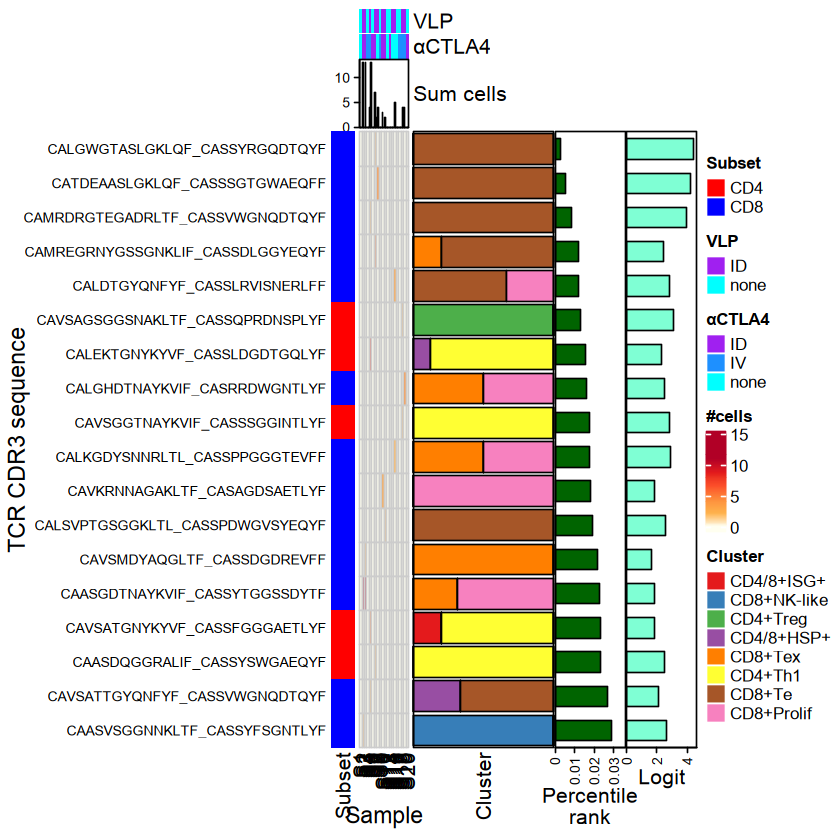

In [50]:
row_ha_r <- rowAnnotation('Cluster' = anno_barplot(mat_freq_subpop/rowSums(mat_freq_subpop), bar_width = 0.9, width = unit(2, 'cm'), 
                                          gp = gpar(fill = brewer.pal(8,'Set1')), axis=F),
                          'Percentile\nrank' = anno_barplot(mat_freq_sample$Percentile, ylim=c(0,0.034),
                                                    gp = gpar(fill = 'darkgreen')), 
                        'Logit'=anno_barplot(mat_freq_sample$Logit, 
                                             gp = gpar(fill = 'aquamarine')), 
                        width=unit(6,'cm'))
row_ha_l <- rowAnnotation('Subset'=mat_freq_sample$subpopulation, col = list(Subset = c('CD4'='red','CD8'='blue'))) 
col_ha <- HeatmapAnnotation('VLP'= tc@meta.data %>% select(sample, VLP, aCTLA4) %>% distinct() %>% pull(VLP),
                           'αCTLA4'= tc@meta.data %>% select(sample, VLP, aCTLA4) %>% distinct() %>% pull(aCTLA4),
                            'Sum cells'=anno_barplot(matrix(nc = 2, c(colSums(mat_freq_sample_cd8[,1:20]), colSums(mat_freq_sample_cd4[,1:20]))),
                                               height=unit(1.5,'cm'), beside = TRUE, attach = TRUE, gp = gpar(fill = c('blue','red'))),
                           col=list('VLP'=c('none'='cyan','ID'='purple'), 'αCTLA4'=c('none'='cyan','ID'='purple','IV'='dodgerblue')),
                           height=unit(2.5,'cm'))
lgd_cluster <- Legend(labels = tc_subpop_specific, title = "Cluster", legend_gp = gpar(fill = brewer.pal(8,'Set1')))
ht <- Heatmap(as.matrix(mat_freq_sample[,1:20]), cluster_rows = F, cluster_columns = F, col = c('ivory',brewer.pal(7, 'YlOrRd')[3:7]),
        row_names_side = 'left', name='#cells', rect_gp = gpar(col = "gray80", lwd = 1),
        row_labels = str_replace(rownames(mat_freq_sample),'[0-9]+',''),
        column_title = 'Sample', row_title = 'TCR CDR3 sequence', column_title_side = 'bottom',
        row_names_gp = gpar(fontsize = 8), left_annotation = row_ha_l, right_annotation = row_ha_r, top_annotation = col_ha)
draw(ht, annotation_legend_list = lgd_cluster, legend_grouping = "original", merge_legend = TRUE)
cairo_pdf('plot/b16_heat_specific_all_tcr.pdf', height=5, width=10)
draw(ht, annotation_legend_list = lgd_cluster, legend_grouping = "original", merge_legend = TRUE)
dev.off()

In [51]:
highlight_clonotype <- function(seurat, clonotype, column='CTaa')
{
    seurat$hl <- 'Other'
    for(ct_i in clonotype)
    {
        if(str_detect(ct_i,'_'))
        {
            ct_iab <- str_split_fixed(ct_i, '_', 2)
            seurat$hl[str_detect(seurat@meta.data[,column], ct_iab[1,1]) & str_detect(seurat@meta.data[,column], ct_iab[1,2])] <- ct_i
        }
        else
        {
            seurat$hl[str_detect(seurat@meta.data[,column], ct_i)] <- ct_i
        }
    }
    df <- arrange(seurat@meta.data, desc(hl))
    g <- ggplot(df, aes(x=umap_1, y=umap_2, color=hl, size=hl)) + theme_dr() + geom_point() + 
        scale_color_manual(values=c(brewer.pal(9, 'Set1')[1:(length(unique(seurat$hl))-1)], 'grey80')) + 
        scale_size_manual(values=c(rep(2,length(unique(df$hl))-1), 1)) + 
        theme(panel.grid=element_blank(), legend.position='top', legend.direction='vertical') + labs(color='Clonotype') + 
        guides(color = guide_legend(override.aes = list(size=2)), size='none')
    return(g)
}

In [52]:
highlight_umap_list <- list()
for(sample_i in colnames(mat_freq_sample[,1:20])[apply(mat_freq_sample[,1:20],2,sum) > 0])
{
    highlight_umap_list[[sample_i]] <- highlight_clonotype(subset(tc_tcr, sample == sample_i ), 
                              mat_freq_sample[,1:20] %>% filter(!!as.symbol(sample_i)>0) %>% rownames()) +
        labs(title=sample_i) + 
        guides(color=guide_legend(ncol=1))
}

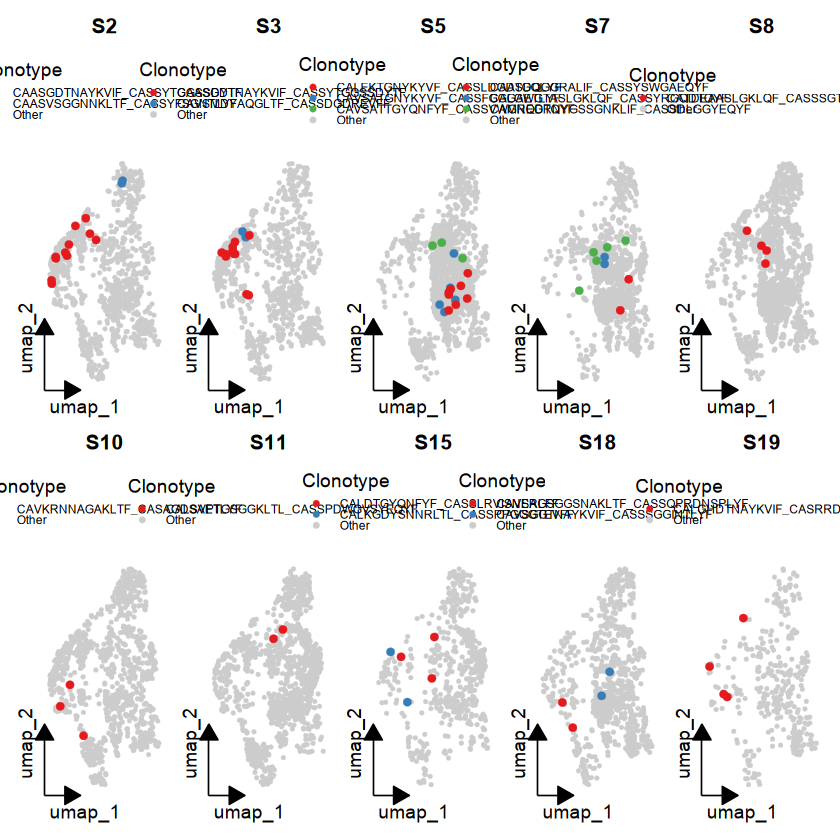

In [53]:
wrap_plots(highlight_umap_list, nrow=2) & theme(legend.text=element_text(size=7), plot.title=element_text(size=12, face='bold', hjust=0.5), 
                                        legend.key.height=unit(0.3,'lines'))
ggsave('plot/b16_umap_tcr_specific_sample.pdf', width=12, height=8, device=pdf)